# Testing out numerical solver code

## current setup
implicit - explicit solver with an implicit multigrid solver for the diffusion term and RK45 for the reaction term.

## Objectives 

## Model considerations 
* Species
    1. Cell density (sender and pulse cells)
    1. Nutrient density 
    1. mScarlet
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Constitutive fluorescence
        * Basal protein expression 
        * initial protein concentration set to fixed point of max nutrient
    1. Dilution and degradation 
        * Assume that all proteins are degradation tagged
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xs : Expression rate of protein. 


### Model equations
Species:
* $c_p$ : Propagator cells
* $c_s$ : Sender cells
* $n$ : Nutrient
* $a$ : AHL (cell-cell signaling molecule)
* $s$ : Synthase (protein that creates AHL)
* $r$ : Transcriptional repressor (halts production of synthase)

Parameters
* $h_i$ : Hill coefficient
* $k_i$ : Hill function IC50 concentration
* $r_i$ : Species production rate
* $p_i$ : Species degradation or consumption rate
* $D_i$ : Species diffusion coefficient

Inducer-dependent protein production approximation:

$ H(a, n, k) = \frac{a^n}{k^n + a^n}$

$ H_n(a, n, k) = 1 - H(a,n,k) $

Differential equations

$ \partial_t c_p = D_c \Delta c_p + r_c H(n,h_n,90)\,c_p $

$ \partial_t c_s = D_c \Delta c_p + r_c H(n,h_n,90)\,c_s $

$ \partial_t n = D_n \Delta n - p_n H(n,h_n,90)\,(c_p + c_s) $

$ \partial_t a = D_a \Delta a + r_a\,s\,(c_p+c_s)-p_a\,a $

Where $c_s>0$

$ \partial_t s = D_c \Delta s  + (r_s\,c_s - r_c\,s)\,H(n,h_n,90) - p_s\,s$

Where $c_p>0$

$ \partial_t s = D_c \Delta s  + (r_s\,c_p\, H(a,h_s,k_s) H_n(r,h_C,k_C) - r_c\,s)\,H(n,h_n,90) - p_s\,s$

Where both $c_p=0$ and $c_s=0$

$ \partial_t s = D_c \Delta s - p_p\,s$

Where $c_p>0$

$ \partial_t r = D_c \Delta r  + (r_r\,c_p\, H(a,h_r,k_r) - r_c\,r)\,H(n,h_n,90) - p_r\,r$

Where both $c_p=0$ 

$ \partial_t r = D_c \Delta r - p_r\,r$


Inducer-dependent protein production approximation:

$ H(a, n, k) = \frac{a^n}{k^n + a^n}$

Differential equations

$ \partial_t c = D_c \Delta c + r_c H(n,h_n,90)\,c $

$ \partial_t n = D_n \Delta n - k_n H(n,h_n,90)\,c $


In [1]:
# imports
from __future__ import division, print_function

import itertools as itt
import time

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")

import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/home/jparkin/anaconda3/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

# %load_ext memory_profiler
# %load_ext line_profiler
import timeit

from IPython.display import HTML

%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

In [2]:
cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(6)
def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,3, figsize=(10,7))
    axs = axs.flatten()
    im_list = [0,0,0,0,0,0]
    
    # Plot cell densities
    ax_ind = 0
    ax = axs[ax_ind]
    indxs = [cp_i, cs_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[ax_ind] = im
    
    # Plot nutrient densities
    ax_ind = 1
    ax = axs[ax_ind]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[ax_ind] = im
    
    # Plot pulser synthase densities
    ax_ind = 2
    ax = axs[ax_ind]
    indxs = [s_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    indxs = [s_i, cs_i]
    v_arr += im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[ax_ind] = im
    
    # Plot ahl conc
    ax_ind = 3
    ax = axs[ax_ind]
    indxs = [a_i]
    v_arr = im_arr[:,indxs,:,:]
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('ahl')
    im_list[ax_ind] = im
    
    # Plot pulser repressor densities
    ax_ind = 4
    ax = axs[ax_ind]
    indxs = [r_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('repr')
    im_list[ax_ind] = im
    
    # Plot total cellular protein
    ax_ind = 5
    ax = axs[ax_ind]
    indxs = [s_i, r_i]
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cellular protein')
    im_list[5] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [cp_i, cs_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        indxs = [s_i, cs_i]
        frame_arr += im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)
        
        # Plot ahl
        ax = axs[3]
        indxs = [a_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot repr
        ax = axs[4]
        indxs = [cp_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[4].set_array(frame_arr)

        # Plot cellular protein
        ax = axs[5]
        indxs = [s_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[5].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
#     fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


def prep_initial_condition(cs_spots, cp_spots, ahl_spots, dims, p0, A):
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    species, n_h, n_w = dims
    
    cs_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cs_spots:
        cs_cells += disk(cs_cells, np.array(center), scale_s)*od
        
    cp_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cp_spots:
        cp_cells += disk(cp_cells, np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, np.array(center), scale_s)*2.5e3
    
    # Set initial conditions
    for ind, cell_arr in zip([cs_i, cp_i], [cs_cells, cp_cells]):
        A[ind,:,:] += cell_arr
#         A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[a_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A



# this no cell diffusion, no nutrient diffusion, seems to work

In [3]:
import importlib
from omnisim import nodc_omnisim as oms
oms = importlib.reload(oms)

In [4]:

# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,      rc,        rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([0*1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  0, (1.6e-2),
# Da,   xa,                xs,  xS,
2e-4, (1e-6)/(16/2.25), 250, 200, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.005], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 0.01

simmer = oms.Simulator(4)
scale = simmer.scale
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [5]:
simmer.basedims = np.array([2,22])
simmer.set_scale(simmer.scale)

In [6]:

species, nh, nw, dx = simmer.dims
initial_array = np.zeros((species, nh, nw), dtype=np.float64, order='C')
initial_array[n_i,:,:] = 100
initial_array[cs_i,0,:4*scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
# initial_array[cs_i,0,:] = ndi.gaussian_filter(initial_array[cs_i,:,:], scale/8)
initial_array[cp_i,0,4*scale:] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
# initial_array[cp_i,:,:] = ndi.gaussian_filter(initial_array[cp_i,:,:], scale/8)
# for ind in [cp_i, cs_i]:
#     threshed = initial_array[ind,:,:] > min_od
#     initial_array[ind,:,:] = initial_array[ind,:,:]*threshed

simmer.initial_array = initial_array


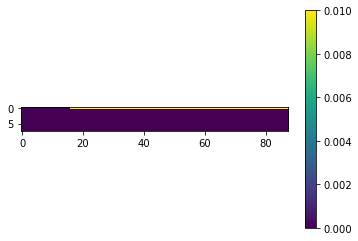

In [7]:
# simmer.initial_array.shape = simmer.dims[:-1]
plt.imshow(simmer.initial_array[cp_i,...])
plt.colorbar()

In [8]:
# simmer.initial_array = initial_array
# simmer.t_eval = np.arange(0,24*60*60,2.0).astype(np.float)
simmer.set_p0(p0)
_, nh, nw, dx = simmer.dims
simmer.t_eval = np.linspace(0,15*60*60,200)
rtime = time.time()
print('start')
simmer.sim(p0, method='RK45')
# simmer.sim(p0, method='BDF')
rtime = time.time() - rtime
print(rtime/60)

start


/home/jparkin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


0.08525186777114868


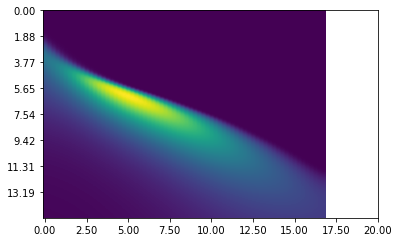

In [9]:
plt.imshow(simmer.sim_arr[:,s_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

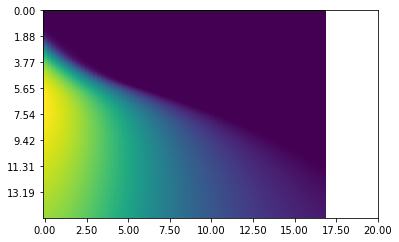

In [10]:
plt.imshow(simmer.sim_arr[:,r_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

(-1.0, 5.0)

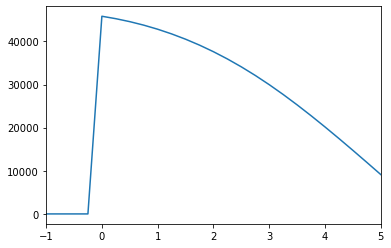

In [11]:
plt.plot(np.arange(simmer.dims[2])/scale-4, simmer.sim_arr[70,r_i,0,:])
plt.xlim([-1,5])

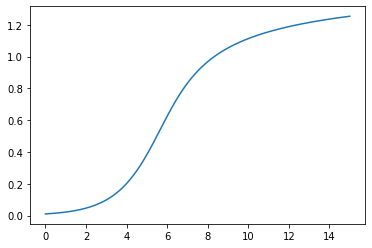

In [12]:
plt.plot(simmer.sim_tvc/3600,simmer.sim_arr[:,cp_i,0,20])

In [301]:
movie_obj = write_movie(simmer.sim_arr[:,:,:,::2], simmer.sim_tvc, skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

In [13]:

# Define parameter values to sample
# Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
xs=0
p0 = np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])

# simmer.t_eval = np.arange(0,24*60*60,2.0).astype(np.float)
# simmer.basedims = np.array([2,22])
# simmer.set_scale(simmer.scale)
# simmer.set_p0(p0)

species, nh, nw, dx = simmer.dims
initial_array = np.zeros((species, nh, nw), dtype=np.float64, order='C')
initial_array[n_i,:,:] = 100
initial_array[cs_i,0,:4*scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
# initial_array[cs_i,0,:] = ndi.gaussian_filter(initial_array[cs_i,:,:], scale/8)
initial_array[cp_i,0,4*scale:] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
# initial_array[cp_i,:,:] = ndi.gaussian_filter(initial_array[cp_i,:,:], scale/8)
# for ind in [cp_i, cs_i]:
#     threshed = initial_array[ind,:,:] > min_od
#     initial_array[ind,:,:] = initial_array[ind,:,:]*threshed

simmer.initial_array = initial_array


simmer.t_eval = np.linspace(0,15*60*60,200)
rtime = time.time()
print('start')
simmer.sim(p0, method='RK45')
# simmer.sim(p0, method='BDF')
rtime = time.time() - rtime
print(rtime/60)

start


/home/jparkin/anaconda3/lib/python3.7/site-packages/scipy/integrate/_ivp/common.py:41: UserWarning: The following arguments have no effect for a chosen solver: `jac`.
  .format(", ".join("`{}`".format(x) for x in extraneous)))


0.08608954747517904


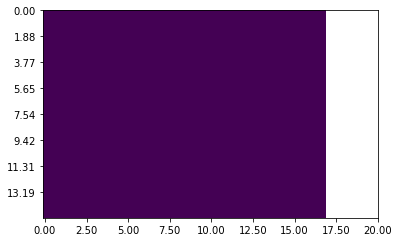

In [14]:
plt.imshow(simmer.sim_arr[:,s_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

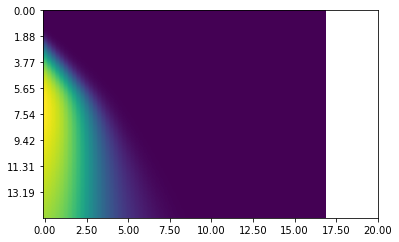

In [15]:
plt.imshow(simmer.sim_arr[:,r_i,0,20:],aspect=1/4)
_ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
_ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

In [305]:
movie_obj = write_movie(simmer.sim_arr, simmer.sim_tvc, skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

(-1.0, 5.0)

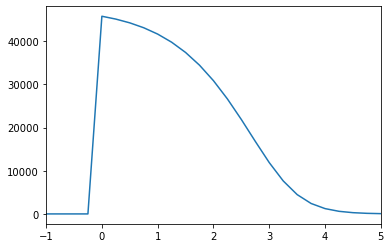

In [16]:
plt.plot(np.arange(simmer.dims[2])/scale-4, simmer.sim_arr[70,r_i,0,:])
plt.xlim([-1,5])

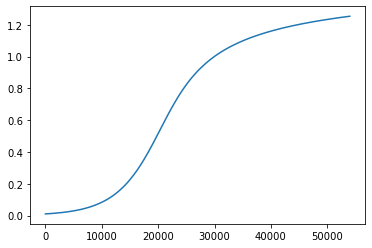

In [17]:
plt.plot(simmer.sim_tvc, simmer.sim_arr[:,cs_i,0,0])

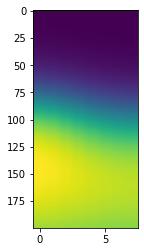

In [19]:
plt.imshow(simmer.sim_arr[:,a_i,:,18],aspect=1/12)
# _ = plt.yticks(np.arange(0,200,25),['{:0.2f}'.format(xx/3600) for xx in simmer.t_eval[np.arange(0,200,25)]])
# _ = plt.xticks(np.arange(0,nw,10),['{:0.2f}'.format(xx) for xx in np.arange(0,nw,10)/scale])

/home/jparkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


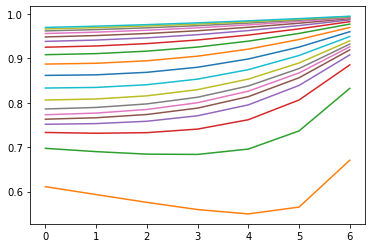

In [22]:
plt.plot(simmer.sim_arr[::10,a_i,1:,0].T/simmer.sim_arr[::10,a_i,:-1,0].T)

# this no cell diffusion, with nutrient diffusion, go for 3d 

In [107]:
import importlib
from omnisim import nodc_3d_omnisim as oms
oms = importlib.reload(oms)
# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,      rc,        rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([0*1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, (1.6e-2),
# Da,   xa,                xs,  xS,
7e-4, (1e-2)/(16/2.25)**2, 250, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.05], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 0.1

simmer = oms.Simulator(8)
scale = simmer.scale
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [108]:
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
# simmer.set_scale(8)
simmer.t_eval = np.arange(0,12*60*60,2).astype(np.float)

simmer.set_p0(p0)

cs_slice, cp_slice, n_slice, a_slice, s_slice, r_slice = simmer.species_slices
scale = simmer.scale

initial_array = np.zeros((arr_z, nh, nw), dtype=np.float64, order='C') + 1e-5
initial_array[n_slice] = 100
s_scale = np.int(scale/2)
initial_array[cs_slice][0,s_scale:-s_scale,s_scale:2*scale+s_scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
initial_array[cs_slice][0,:,:] = ndi.gaussian_filter(initial_array[cs_slice][0,...], scale/4)
initial_array[cp_slice][0,s_scale:-s_scale,3*scale:-s_scale] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
initial_array[cp_slice][0,:,:] = ndi.gaussian_filter(initial_array[cp_slice][0,...], scale/4)
for ind in [cp_slice, cs_slice]:
    threshed = initial_array[ind] > min_od
    initial_array[ind] = initial_array[ind]*threshed
simmer.initial_array = initial_array.copy()

In [109]:
# simmer.set_p0(p0)

from omnisim.solvers import cn_gmres_3d
cn_gmres_3d = importlib.reload(cn_gmres_3d)
impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=5e-1)

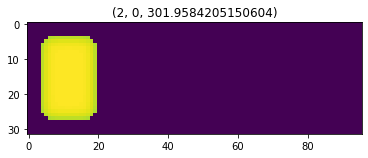

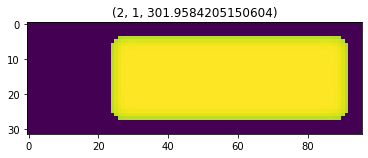

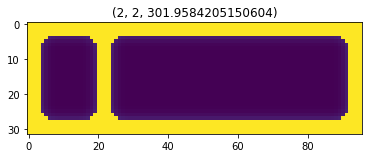

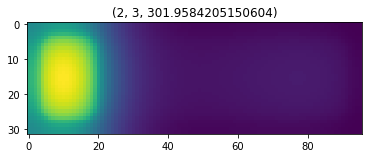

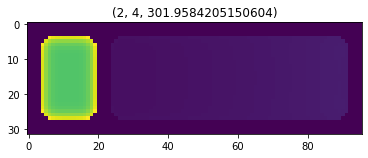

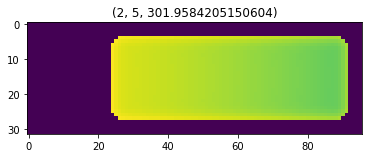

In [110]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
ys = []
ts = []
for dt in [2]:#,2,5e-1,5e-2]:
    simmer.initial_array = initial_array.copy()
    impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=dt)
    n_loops = 10000
    rtime = time.time()
    for i in np.arange(n_loops):
        impexp._step_impl()
        if i%20:
            continue
        else:
            ys.append(impexp.y.copy())
            ts.append(i*dt)
    rtime = time.time() - rtime
    err_arr = impexp.y
    err_arr = err_arr.reshape((arr_z,nh,nw))
    for i in np.arange(species):
        plt.figure()
        plt.imshow(err_arr[simmer.z0_slice][i,:,:])
        plt.title((dt, i, rtime))
#     b = cnmg.cn_rhsb_wrxn(x)
# #     cnmg.w_cycle(x,b,0)
#     out = splinalg.gmres(A, b, x)
# #     x = out[0]
#     if np.mod(i,n_loops/10)==0:
#         x = impexp.y.copy()
#         print(i)
#         print(impexp.cnmg_solver.dt)
#         x.shape = (ns,nh,nw)
#         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
#         x.shape = ns*nh*nw

In [111]:
ys_reshaped = [xx.reshape((1,arr_z,nh,nw)) for xx in ys]

In [112]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [113]:
movie_obj = write_movie(ys_stack[:,simmer.z0_slice[0],:,:], np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

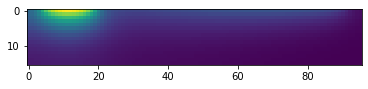

In [114]:
_ = plt.imshow(ys_stack[200,a_slice[0],np.int(nh//2),:],vmin=0)

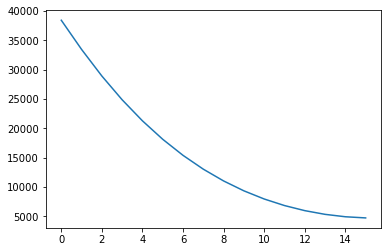

In [115]:
_ = plt.plot(ys_stack[200,a_slice[0],np.int(nh//2),40])

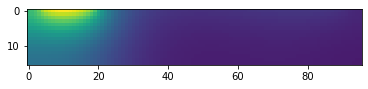

In [116]:
_ = plt.imshow(err_arr[simmer.species_slices[a_i]][:,np.int(nh//2),:],interpolation='none',vmin=0)

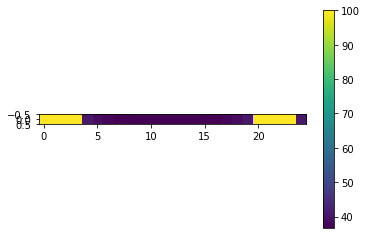

In [117]:
_ = plt.imshow(err_arr[simmer.species_slices[n_i]][:5,np.int(nh//2),:25])
plt.colorbar()

In [118]:
import importlib
from omnisim import nodc_3d_omnisim as oms
oms = importlib.reload(oms)
# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,      rc,        rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([0*1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, (1.6e-2),
# Da,   xa,                xs,  xS,
7e-4, (1e-2)/(16/2.25)**2, 0, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.05], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 0.1

simmer = oms.Simulator(8)
scale = simmer.scale
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [119]:
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
# simmer.set_scale(8)
simmer.t_eval = np.arange(0,12*60*60,2).astype(np.float)

simmer.set_p0(p0)

cs_slice, cp_slice, n_slice, a_slice, s_slice, r_slice = simmer.species_slices
scale = simmer.scale

initial_array = np.zeros((arr_z, nh, nw), dtype=np.float64, order='C') + 1e-5
initial_array[n_slice] = 100
s_scale = np.int(scale/2)
initial_array[cs_slice][0,s_scale:-s_scale,s_scale:2*scale+s_scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
initial_array[cs_slice][0,:,:] = ndi.gaussian_filter(initial_array[cs_slice][0,...], scale/4)
initial_array[cp_slice][0,s_scale:-s_scale,3*scale:-s_scale] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
initial_array[cp_slice][0,:,:] = ndi.gaussian_filter(initial_array[cp_slice][0,...], scale/4)
for ind in [cp_slice, cs_slice]:
    threshed = initial_array[ind] > min_od
    initial_array[ind] = initial_array[ind]*threshed
simmer.initial_array = initial_array.copy()

In [120]:
# simmer.set_p0(p0)

from omnisim.solvers import cn_gmres_3d
cn_gmres_3d = importlib.reload(cn_gmres_3d)
impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=5e-1)

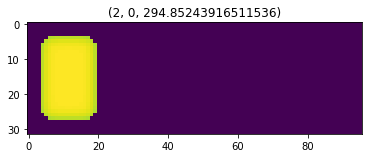

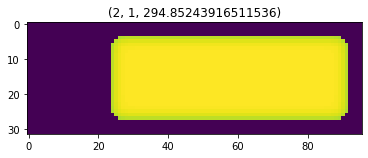

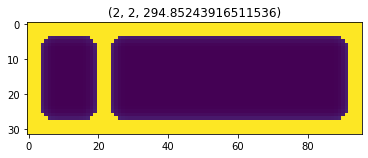

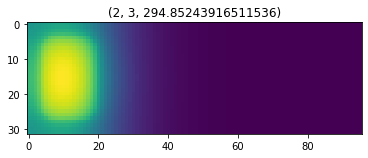

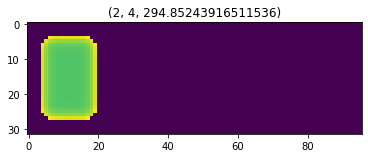

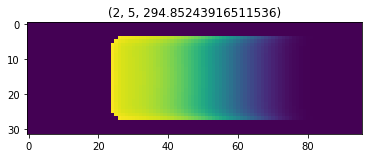

In [121]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
ys = []
ts = []
for dt in [2]:#,2,5e-1,5e-2]:
    simmer.initial_array = initial_array.copy()
    impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=dt)
    n_loops = 10000
    rtime = time.time()
    for i in np.arange(n_loops):
        impexp._step_impl()
        if i%20:
            continue
        else:
            ys.append(impexp.y.copy())
            ts.append(i*dt)
    rtime = time.time() - rtime
    err_arr = impexp.y
    err_arr = err_arr.reshape((arr_z,nh,nw))
    for i in np.arange(species):
        plt.figure()
        plt.imshow(err_arr[simmer.z0_slice][i,:,:])
        plt.title((dt, i, rtime))
#     b = cnmg.cn_rhsb_wrxn(x)
# #     cnmg.w_cycle(x,b,0)
#     out = splinalg.gmres(A, b, x)
# #     x = out[0]
#     if np.mod(i,n_loops/10)==0:
#         x = impexp.y.copy()
#         print(i)
#         print(impexp.cnmg_solver.dt)
#         x.shape = (ns,nh,nw)
#         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
#         x.shape = ns*nh*nw

In [122]:
ys_reshaped = [xx.reshape((1,arr_z,nh,nw)) for xx in ys]

In [123]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [124]:
movie_obj = write_movie(ys_stack[:,simmer.z0_slice[0],:,:], np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

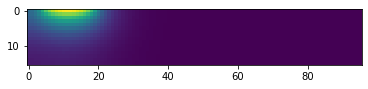

In [125]:
_ = plt.imshow(ys_stack[200,a_slice[0],np.int(nh//2),:],vmin=0)

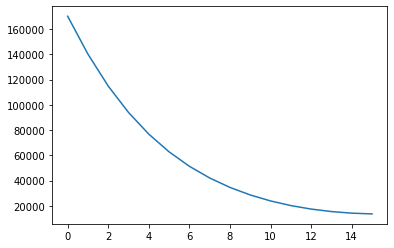

In [129]:
_ = plt.plot(ys_stack[200,a_slice[0],np.int(nh//2),10])

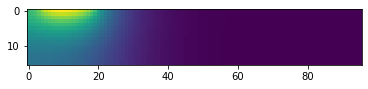

In [127]:
_ = plt.imshow(err_arr[simmer.species_slices[a_i]][:,np.int(nh//2),:],interpolation='none',vmin=0)

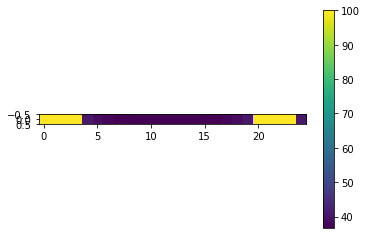

In [128]:
_ = plt.imshow(err_arr[simmer.species_slices[n_i]][:5,np.int(nh//2),:25])
plt.colorbar()

# this no cell diffusion, with nutrient diffusion, go for 3d 

In [107]:
import importlib
from omnisim import nodc_3d_omnisim as oms
oms = importlib.reload(oms)
# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Params :    ,Dc,      rc,        rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([0*1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, (1.6e-2),
# Da,   xa,                xs,  xS,
7e-4, (1e-2)/(16/2.25)**2, 250, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.05], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 0.1

simmer = oms.Simulator(8)
scale = simmer.scale
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [108]:
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
# simmer.set_scale(8)
simmer.t_eval = np.arange(0,12*60*60,2).astype(np.float)

simmer.set_p0(p0)

cs_slice, cp_slice, n_slice, a_slice, s_slice, r_slice = simmer.species_slices
scale = simmer.scale

initial_array = np.zeros((arr_z, nh, nw), dtype=np.float64, order='C') + 1e-5
initial_array[n_slice] = 100
s_scale = np.int(scale/2)
initial_array[cs_slice][0,s_scale:-s_scale,s_scale:2*scale+s_scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
initial_array[cs_slice][0,:,:] = ndi.gaussian_filter(initial_array[cs_slice][0,...], scale/4)
initial_array[cp_slice][0,s_scale:-s_scale,3*scale:-s_scale] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
initial_array[cp_slice][0,:,:] = ndi.gaussian_filter(initial_array[cp_slice][0,...], scale/4)
for ind in [cp_slice, cs_slice]:
    threshed = initial_array[ind] > min_od
    initial_array[ind] = initial_array[ind]*threshed
simmer.initial_array = initial_array.copy()

In [109]:
# simmer.set_p0(p0)

from omnisim.solvers import cn_gmres_3d
cn_gmres_3d = importlib.reload(cn_gmres_3d)
impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=5e-1)

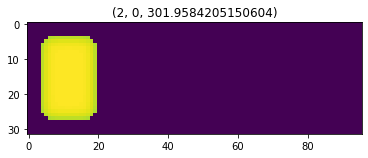

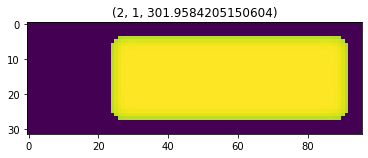

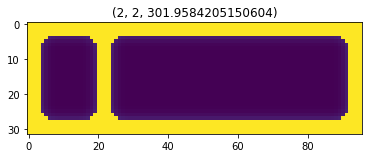

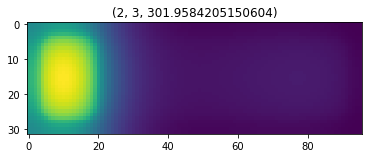

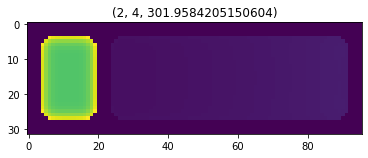

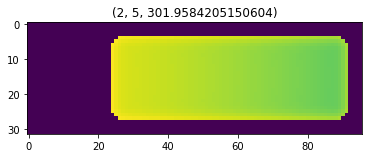

In [110]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
ys = []
ts = []
for dt in [2]:#,2,5e-1,5e-2]:
    simmer.initial_array = initial_array.copy()
    impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=dt)
    n_loops = 10000
    rtime = time.time()
    for i in np.arange(n_loops):
        impexp._step_impl()
        if i%20:
            continue
        else:
            ys.append(impexp.y.copy())
            ts.append(i*dt)
    rtime = time.time() - rtime
    err_arr = impexp.y
    err_arr = err_arr.reshape((arr_z,nh,nw))
    for i in np.arange(species):
        plt.figure()
        plt.imshow(err_arr[simmer.z0_slice][i,:,:])
        plt.title((dt, i, rtime))
#     b = cnmg.cn_rhsb_wrxn(x)
# #     cnmg.w_cycle(x,b,0)
#     out = splinalg.gmres(A, b, x)
# #     x = out[0]
#     if np.mod(i,n_loops/10)==0:
#         x = impexp.y.copy()
#         print(i)
#         print(impexp.cnmg_solver.dt)
#         x.shape = (ns,nh,nw)
#         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
#         x.shape = ns*nh*nw

In [111]:
ys_reshaped = [xx.reshape((1,arr_z,nh,nw)) for xx in ys]

In [112]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [113]:
movie_obj = write_movie(ys_stack[:,simmer.z0_slice[0],:,:], np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

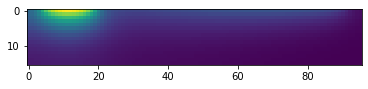

In [114]:
_ = plt.imshow(ys_stack[200,a_slice[0],np.int(nh//2),:],vmin=0)

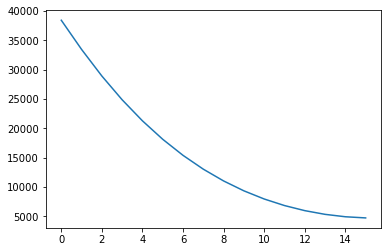

In [115]:
_ = plt.plot(ys_stack[200,a_slice[0],np.int(nh//2),40])

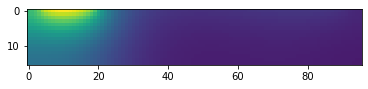

In [116]:
_ = plt.imshow(err_arr[simmer.species_slices[a_i]][:,np.int(nh//2),:],interpolation='none',vmin=0)

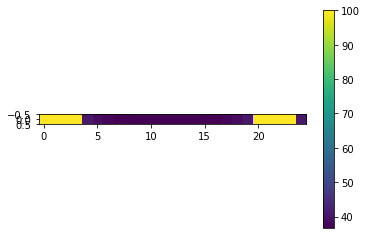

In [117]:
_ = plt.imshow(err_arr[simmer.species_slices[n_i]][:5,np.int(nh//2),:25])
plt.colorbar()

# this no cell diffusion, with 2d nutrient diffusion, go for 3d, full crank not impexp

In [226]:
Da*dt/(1/scale**2)

0.0448

In [211]:
import importlib
from omnisim import nodc_3d_omnisim as oms
oms = importlib.reload(oms)
# array([1.13884719e-06, 2.57810284e-04, 6.79690366e+01, 3.97094713e+00,
#        1.57994650e-02])
# Define parameter values to sample
od0 = 0.2

simmer = oms.Simulator(2)
scale = simmer.scale
# simmer.set_scale(8)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [212]:

# Params :    ,Dc,      rc,        rS, rR,  Hn, Kn,   Dn,      kn,                   
p0 = np.array([0*1e-5,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, (1.6e-2),
# Da,   xa,                xs,  xS,
7e-4, (1e-2)/(16/2.25)**2, 250, 300, 
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.05], dtype=np.float64)

Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0

# simmer.set_scale(8)
simmer = oms.Simulator(8)

simmer.t_eval = np.arange(0,12*60*60,2).astype(np.float)

scale = simmer.scale
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5

simmer.set_p0(p0)

cs_slice, cp_slice, n_slice, a_slice, s_slice, r_slice = simmer.species_slices
scale = simmer.scale

initial_array = np.zeros((arr_z, nh, nw), dtype=np.float64, order='C') + 1e-5
initial_array[n_slice] = 100
s_scale = np.int(scale/2)
initial_array[cs_slice][0,s_scale:-s_scale,s_scale:2*scale+s_scale] = od0
# initial_array[cs_i,:,:] = od0*(np.random.random((nh,nw))<0.19)
initial_array[cs_slice][0,:,:] = ndi.gaussian_filter(initial_array[cs_slice][0,...], scale/4)
initial_array[cp_slice][0,s_scale:-s_scale,3*scale:-s_scale] = od0
# initial_array[cp_i,:,:] = od0*(np.random.random((nh,nw))<0.25)
initial_array[cp_slice][0,:,:] = ndi.gaussian_filter(initial_array[cp_slice][0,...], scale/4)
for ind in [cp_slice, cs_slice]:
    threshed = initial_array[ind] > min_od
    initial_array[ind] = initial_array[ind]*threshed
simmer.initial_array = initial_array.copy()

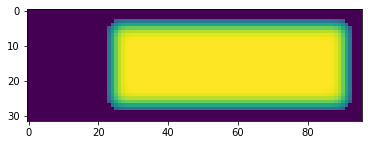

In [214]:
plt.imshow(initial_array[cp_slice][0,:,:])

In [215]:
# simmer.set_p0(p0)

from omnisim.solvers import cn_gmres_3d
cn_gmres_3d = importlib.reload(cn_gmres_3d)
# impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=5e-1)

0
0.0
20
8.44615758392962
40
9.035849515106914
60
9.2576872799348
80
9.363563537646836
100
9.4058952658833
120
9.446655630226049
140
9.472048665986646
160
9.487069665717138
180
9.515568975211755
200
9.527293547280152
220
9.529905989212182
240
9.52633690866521
260
9.5304356380018
280
9.535362733961048
300
9.538006378691549
320
9.54639624980595
340
9.55433896720389
360
9.526138365597573
380
9.487254263908781
400
9.451636112807376
420
9.41618753282001
440
9.38251466722561
460
9.353216706832658
480
9.323546949028442
500
9.295291807438172
520
9.269755363229129
540
9.24445751419136
560
9.221167702766943
580
9.204296744902551
600
9.188970484039727
620
9.17260550543034
640
9.152692066633135
660
9.137769017431893
680
9.121827992470617
700
9.105316155356807
720
9.095358951249517
740
9.085681524143428
760
9.069091505682902
780
9.055623467932001
800
9.043061870717525
820
9.031439638217574
840
9.01562478345143
860
8.997567130757707
880
8.984452368428805
900
8.968983124893127
920
8.958591135711117
9

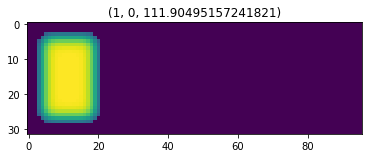

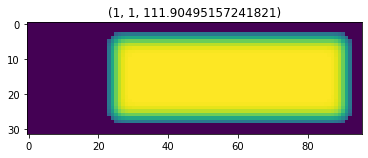

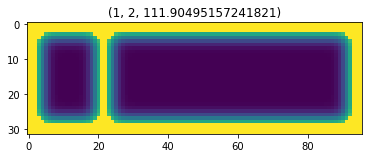

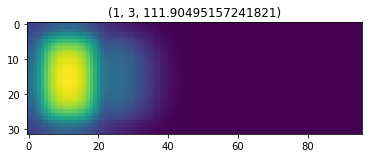

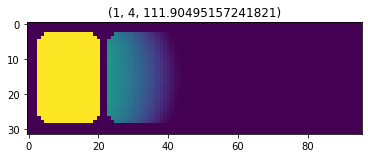

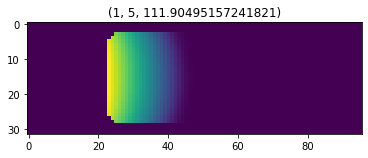

In [216]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()
species = 6
ns, nz, nh, nw, _ = simmer.dims
arr_z = nz + 5
ys = []
ts = []
for dt in [1]:#,2,5e-1,5e-2]:
    simmer.initial_array = initial_array.copy()
    impexp = cn_gmres_3d.CNMGRK(simmer, 0, 2*60, first_step=dt)
    n_loops = 1000
    rtime = time.time()
    for i in np.arange(n_loops):
        status, msg = impexp._step_impl()
        if status==False:
            print(msg)
            break
        if i%20:
            continue
        else:
            print(i)
            print(dt*i/(time.time() - rtime))
            ys.append(impexp.y.copy())
            ts.append(i*dt)
    rtime = time.time() - rtime
    err_arr = impexp.y
    err_arr = err_arr.reshape((arr_z,nh,nw))
    for i in np.arange(species):
        plt.figure()
        plt.imshow(err_arr[simmer.z0_slice][i,:,:])
        plt.title((dt, i, rtime))
#     b = cnmg.cn_rhsb_wrxn(x)
# #     cnmg.w_cycle(x,b,0)
#     out = splinalg.gmres(A, b, x)
# #     x = out[0]
#     if np.mod(i,n_loops/10)==0:
#         x = impexp.y.copy()
#         print(i)
#         print(impexp.cnmg_solver.dt)
#         x.shape = (ns,nh,nw)
#         axs[np.int(10*i/n_loops)].imshow(x[[cp_i,s_i],:,:].prod(axis=0))
#         x.shape = ns*nh*nw

In [156]:
print(rtime/60)

0.12193039258321127


In [104]:
y = impexp.y
difmat = simmer.jacobian.get_dif_jac()
rxnmat = simmer.jacobian.get_rxn_jac(0,y)
d_y = simmer.f_ivp_wrapper(0,y)


In [105]:
A = impexp.cnmg_solver.cn_lhsA(difmat, rxnmat)
b = impexp.cnmg_solver.cn_rhsb(y, d_y, difmat, rxnmat)

In [113]:
y_out, info = sparse.linalg.gmres(A,b,y+d_y*impexp.dt,tol=simmer.rtol,atol=1e-3)

In [115]:
info

99840

<9984x9984 sparse matrix of type '<class 'numpy.float64'>'
	with 50696 stored elements in Compressed Sparse Row format>

In [217]:
ys_reshaped = [xx.reshape((1,arr_z,nh,nw)) for xx in ys]

In [218]:
ys_stack = np.concatenate(ys_reshaped,axis=0)

In [219]:
movie_obj = write_movie(ys_stack[:,simmer.z0_slice[0],:,:], np.array(ts), skip=1, n_frames=200)
HTML(movie_obj.to_html5_video())

In [220]:
_ = plt.imshow(ys_stack[200,a_slice[0],np.int(nh//2),:],vmin=0)

IndexError: index 200 is out of bounds for axis 0 with size 50

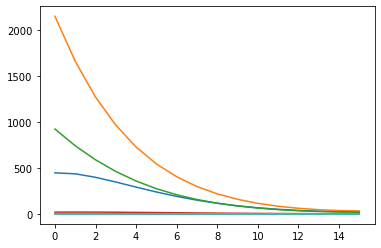

In [224]:
_ = plt.plot(ys_stack[20,a_slice[0],np.int(nh//2),::10])

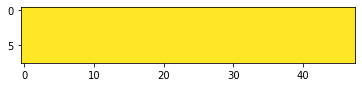

In [72]:
_ = plt.imshow(err_arr[simmer.species_slices[a_i]][:,np.int(nh//2),:],interpolation='none',vmin=0)

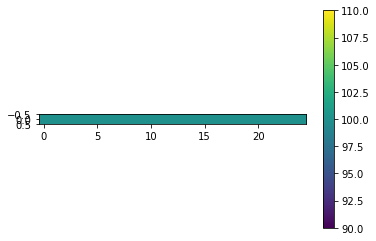

In [73]:
_ = plt.imshow(err_arr[simmer.species_slices[n_i]][:5,np.int(nh//2),:25])
plt.colorbar()